# Table of Contents
- Error distribution
- Circuit-level noise
    - Noiseless
    - Dephasing noise + measurement noise
    - Depolarizing noise + measurement noise
    - Asymmetric depol 1q + depol 2q + measurement noise

To do:
- Verify the noise channels with comparision to native qulacs' noise maps

In [1]:
# This cell can take about 20 seconds to run
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import itertools, pickle, os
from tqdm import tqdm


from qulacs import QuantumState, QuantumCircuit, NoiseSimulator, Observable
from qulacs.gate import Measurement, H, CNOT, CZ, X, Y, Z, Probabilistic, Identity, Adaptive, DenseMatrix
from qulacs import PauliOperator

from tool import qec
from tool.check_encoding import print_state, run_stabilizer_circuit, check_encoding, get_state_dict, gatedict, run_stabilizer_circuit_old


In [2]:
# def compare_state(state1, state2):
#     num_qubits = state1.get_qubit_count()
#     computational_states = [''.join(map(str,i))[::-1] for i in itertools.product([0, 1], repeat=num_qubits)]
#     state1_dict = get_state_dict(state1.get_vector(),computational_states)
#     state2_dict = get_state_dict(state2.get_vector(),computational_states)
#     return state1_dict == state2_dict

# can't just keep track of measured qubits bc even though a measured qubit
# is not measured later, there's an X error on it that will propagate

# import itertools

# for target_outcomes in itertools.product(['0', '1'], repeat=3):
#     target_outcomes = ''.join(target_outcomes)
#     state1, _ = run_stabilizer_circuit_old(gate_sequence, num_qubits, num_meas, target_outcomes)
#     state2, _ = run_stabilizer_circuit(gate_sequence, num_qubits, num_meas, target_outcomes)
#     print(target_outcomes, compare_state(state1, state2))

In [3]:
# Z-checks: Z0123, Z2415, Z5623 prep logical+ then add Hadarmard so prepare logical0
gate_sequence = [
    *[('H', (i,)) for i in range(7)],

    ('H', (8,)), ('H', (9,)),
    *[('CX', (control, target)) for control, target in zip([8,9,0,1,2,3,9,8],[7,8,7,7,8,9,8,7])],
    ('H', (8,)), ('H', (9,)),
    ('Meas', (7,0)),
    ('Meas', (8,1)),
    ('Meas', (9,2)),

    ('H', (7,)), ('H', (10,)),
    *[('CX', (control, target)) for control, target in zip([7,10,2,4,1,5,10,7],[8,7,8,8,7,10,7,8])],
    ('H', (7,)), ('H', (10,)),
    ('Meas', (8,3)),
    ('Meas', (7,4)),
    ('Meas', (10,5)),

    ('H', (8,)), ('H', (9,)),
    *[('CX', (control, target)) for control, target in zip([8,9,5,6,2,3,9,8],[10,8,10,10,8,9,8,10])],
    ('H', (8,)), ('H', (9,)),
    ('Meas', (10,6)),
    ('Meas', (8,7)),
    ('Meas', (9,8)),

    *[('H', (i,)) for i in range(7)],
]

stabilizer_generators = ['ZZZZ---','-ZZ-ZZ-','--ZZ-ZZ',
                         'XXXX---','-XX-XX-','--XX-XX', 'ZZZZZZZ']
stabilizer_generators = [list(stab) for stab in stabilizer_generators]
stabilizer_group = qec.compute_stabilizer_group(stabilizer_generators)


num_qubits = 11
num_meas = 9
num_data = 7

obs = Observable(num_qubits)
obs.add_operator(1, '')
observables = [[obs,'']]
for elem in stabilizer_group:
    obs_string = ''
    Y_count = 0
    for i in range(num_data):
        if elem[i] != '-':
            obs_string += f' {elem[i]} {i}'
            if elem[i] == 'Y':
                Y_count += 1
    obs = Observable(num_qubits)
    # note that XZ = -iY
    obs.add_operator((-1j)**Y_count, obs_string)
    observables.append([obs, obs_string.replace(' ', '')])

computational_states = [''.join(map(str,i))[::-1] for i in itertools.product([0, 1], repeat=num_qubits)]


# Error distribution

In [4]:
gate_dict = {
    '-': Identity,
    'X': X,
    'Y': Y,
    'Z': Z,
}
def error_distribution(num_data, stabilizer_group, init_state, observables, savename):

    file_path = f'../data/errordist_{savename}.pkl'
    # load the results if already computed
    if os.path.exists(file_path):
        print('Already computed. Loading...')
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        return result['err_dist'], result['err_map'], result['err_counts']
    else:
        print('Computing error distribution...')
        err_dist = {i: {} for i in range(num_data+1)}
        err_map = {}
        err_counts = np.zeros([num_data+1,num_data+1], dtype=int)
        for error in tqdm(itertools.product(['X','Y','Z','-'],repeat=num_data)):
            error = ''.join(error)
            init_weight = qec.pauli_weight(error)
            # apply error to state
            state = init_state.copy()
            for i, gate in enumerate(error):
                gate_dict[gate](i).update_quantum_state(state)

            # compute the observables
            obs_values = np.array([obs[0].get_expectation_value(state) for obs in observables])
            assert abs(obs_values**2 - 1).max() < 1e-10 # should be all 1 or -1
            obs_values = obs_values.round(10).astype(int)

            # compute the equivalent error
            equiv_error, weight = qec.lowest_weight_equivalent(error, stabilizer_group)
            equiv_error = ''.join(equiv_error)
            # check if equivalent error is already recorded
            if equiv_error in err_dist[weight]:
                assert (obs_values == err_dist[weight][equiv_error]).all() # observables should be the same
            else:
                err_dist[weight][equiv_error] = obs_values
            if error != equiv_error:
                err_map[error] = equiv_error
            err_counts[init_weight][weight] += 1

        # save the results
        save_dict = {
            'err_dist': err_dist,
            'err_map': err_map,
            'err_counts': err_counts, 
        }
        with open(file_path, 'wb') as f:
            pickle.dump(save_dict, f)
        return err_dist, err_map, err_counts


logical0, _ = run_stabilizer_circuit(gate_sequence, num_qubits, num_meas, '000000000', verbose=True)
err_dist, err_map, err_counts = error_distribution(num_data, stabilizer_group, logical0, observables, 'Steane_logical0')

print('\nError distribution: \n - Row is the apparent weight\n - Column is the smallest weight after modulo stabilizers')
print(f' e.g. there are {21+168} weight-2 errors but 21 of them are equivalent to weight-1 errors,')
print(' these are the Z errors that reduce to weight-1 errors for logical 0 state')
print(err_counts)

ancilla meas: 000000000
0000000|0000: 0.354  +  0.000i
1111000|0000: 0.354  +  0.000i
0110110|0000: 0.354  +  0.000i
1001110|0000: 0.354  +  0.000i
1010101|0000: 0.354  +  0.000i
0101101|0000: 0.354  +  0.000i
1100011|0000: 0.354  +  0.000i
0011011|0000: 0.354  +  0.000i
Already computed. Loading...

Error distribution: 
 - Row is the apparent weight
 - Column is the smallest weight after modulo stabilizers
 e.g. there are 189 weight-2 errors but 21 of them are equivalent to weight-1 errors,
 these are the Z errors that reduce to weight-1 errors for logical 0 state
[[   1    0    0    0    0    0    0    0]
 [   0   21    0    0    0    0    0    0]
 [   0   21  168    0    0    0    0    0]
 [   7  126  756   56    0    0    0    0]
 [  21  462 2128  224    0    0    0    0]
 [  42  861 3864  336    0    0    0    0]
 [  42  861 3976  224    0    0    0    0]
 [  15  336 1652  184    0    0    0    0]]


## Testing with all possible errors

In [5]:
obs_dist = [[],[],[],[],[],[],[],[]]
for error in itertools.product(['X','Y','Z','-'],repeat=num_data):
    apparent_weight = qec.pauli_weight(error)
    error = ''.join(error)
    if error in err_map:
        error = err_map[error]
    weight = qec.pauli_weight(error)
    obs_dist[apparent_weight].append(err_dist[weight][error])
obs_dist = [np.array(obs_dist[i]) for i in range(num_data+1)]
print('Number of errors of weight 0 to 7:')
print([len(obs_dist[i]) for i in range(num_data+1)])

Number of errors of weight 0 to 7:
[1, 21, 189, 945, 2835, 5103, 5103, 2187]


In [6]:
obs_unique = [np.array(list(err_dist[i].values())) for i in range(4)]
print('Number of unique errors of weight 0 to 3:')
print([len(obs_unique[i]) for i in range(4)])

Number of unique errors of weight 0 to 3:
[1, 21, 98, 8]


In [7]:
num_obs = len(observables)
all_probs = []
for i in range(num_data+1):
    probs = []
    for j in range(4):        
        probs.append((obs_dist[i] @ obs_unique[j].T).sum(1).mean(0)/num_obs)
    assert abs(sum(probs)-1) < 1e-10
    # print(i, '  '.join([f'{p:.3f}' for p in probs]))
    all_probs.append(probs)
all_probs = np.array(all_probs)

print('Probabilities of errors in each weight via dot-product of vectors of observables')
print(all_probs.round(4))

Probabilities of errors in each weight via dot-product of vectors of observables
[[1.     0.     0.     0.    ]
 [0.     1.     0.     0.    ]
 [0.     0.1111 0.8889 0.    ]
 [0.0074 0.1333 0.8    0.0593]
 [0.0074 0.163  0.7506 0.079 ]
 [0.0082 0.1687 0.7572 0.0658]
 [0.0082 0.1687 0.7791 0.0439]
 [0.0069 0.1536 0.7554 0.0841]]


In [8]:
print('Probabilities of errors in each weight from the distribution')
print((err_counts/err_counts.sum(1)[:,None]).round(4))

Probabilities of errors in each weight from the distribution
[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.1111 0.8889 0.     0.     0.     0.     0.    ]
 [0.0074 0.1333 0.8    0.0593 0.     0.     0.     0.    ]
 [0.0074 0.163  0.7506 0.079  0.     0.     0.     0.    ]
 [0.0082 0.1687 0.7572 0.0658 0.     0.     0.     0.    ]
 [0.0082 0.1687 0.7791 0.0439 0.     0.     0.     0.    ]
 [0.0069 0.1536 0.7554 0.0841 0.     0.     0.     0.    ]]


# Circuit-level noise

In [9]:
def common_gate(gatename):
    gate_dict = {
        '-': np.eye(2),
        'X': np.array([[0,1],[1,0]]),
        'Y': np.array([[0,-1j],[1j,0]]),
        'Z': np.array([[1,0],[0,-1]]),
    }
    return gate_dict[gatename]

def weight2_Pauli(pstr, qubits):
    mat_gate = DenseMatrix(qubits,np.kron(common_gate(pstr[0]),common_gate(pstr[1])))
    return mat_gate

def run_noisy_stabilizer_circuit(
        gate_sequence: list[tuple[str, tuple[int]]], 
        num_qubits: int, 
        num_meas: int,
        num_shots: int,
        observables: list, 
        noise_1q = None, # eg: 'X' is bit-flip noise, 'Z' is phase-flip noise
        noise_2q = None,
        meas_noise = None,
        noise_prob_1q = 0.,
        noise_prob_2q = 0.,
        verbose: bool = False
        ):
    '''
    Currently assuming perfect reset
    '''


    if noise_1q:
        op_func_1q = lambda q: [gate_dict[op](q) for op in '-'+noise_1q]
        n1 = len(op_func_1q(0)) - 1
        if type(noise_prob_1q) == float:
            prob_list_1q = [1-noise_prob_1q] + [noise_prob_1q/n1]*n1
        elif len(noise_prob_1q) == n1:
            prob_list_1q = [1-sum(noise_prob_1q)] + noise_prob_1q
        else:
            raise ValueError('noise_prob_1q should be a float or a list of appropriate length')

    if noise_2q:
        op_func_2q = lambda qs: [weight2_Pauli(''.join(err),qs) for err in itertools.product('-'+noise_2q,repeat=2)]
        n2 = len(op_func_2q([0,1])) - 1
        if type(noise_prob_2q) == float:
            prob_list_2q = [1-noise_prob_2q] + [noise_prob_2q/n2]*n2
        elif len(noise_prob_2q) == n2:
            prob_list_2q = [1-sum(noise_prob_2q)] + noise_prob_2q
        else:
            raise ValueError('noise_prob_2q should be a float or a list of appropriate length')

    if meas_noise:
        op_func_meas = lambda q: [gate_dict[op](q) for op in '-X']
        if type(meas_noise) == float:
            prob_list_meas = [[1-meas_noise, meas_noise]]*num_qubits
        elif len(meas_noise) == num_qubits:
            prob_list_meas = [[1-p,p] for p in meas_noise]
        else:
            raise ValueError('meas_noise should be a float or a list of appropriate length') 
        
    # Construct circuit
    circuit = QuantumCircuit(num_qubits)
    for gate, pos in gate_sequence:
        # Add measurement noise
        if meas_noise and gate == 'Meas':
            circuit.add_gate(Probabilistic(prob_list_meas[pos[0]], op_func_meas(pos[0])))
        # Add gate or measurement
        circuit.add_gate(gatedict[gate](*pos))
        # Add gate noise
        if noise_1q and len(pos) == 1:
            circuit.add_gate(Probabilistic(prob_list_1q, op_func_1q(pos[0])))
        if noise_2q and len(pos) == 2:
            circuit.add_gate(Probabilistic(prob_list_2q, op_func_2q(pos)))
        # reset qubit manually at each Measurement
        if gate == 'Meas':
            Reset = Adaptive(X(pos[0]), lambda register: register[-1] == 1)
            circuit.add_gate(Reset) # assume perfect reset

    # Run circuit
    measurements = []
    obs_results = []
    states = []
    for _ in range(num_shots):
        state = QuantumState(num_qubits)
        state.set_zero_state()
        circuit.update_quantum_state(state)   
        measurements.append([state.get_classical_value(i) for i in range(num_meas)])
        obs_results.append([obs.get_expectation_value(state) for obs, _ in observables])
        states.append(state)

    return states, np.array(obs_results), np.array(measurements)

## Noiseless

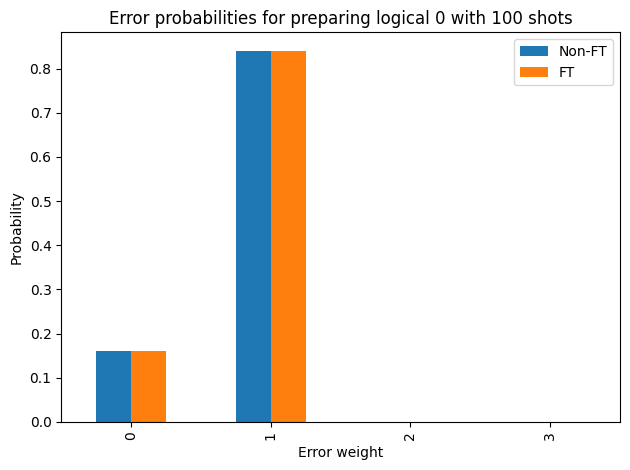

In [10]:
shots = 100
flag_inds = [1,2,4,5,7,8]
states, obs_results, measurements = run_noisy_stabilizer_circuit(gate_sequence, 
                                                                 num_qubits, 
                                                                 num_meas, 
                                                                 shots,
                                                                 observables, 
                                                                 verbose=True)

unflagged = np.where(measurements[:,flag_inds].sum(1) == 0)
probs_nonFT = [np.round((obs_results @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
probs_FT = [np.round((obs_results[unflagged] @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
df = pd.DataFrame(np.stack([probs_nonFT, probs_FT]).T, columns=['Non-FT', 'FT'], index=[f'{i}' for i in range(4)])
df.plot(kind='bar', title=f'Error probabilities for preparing logical 0 with {shots} shots', ylabel='Probability', xlabel='Error weight')
plt.tight_layout()

## Dephasing noise + measurement noise

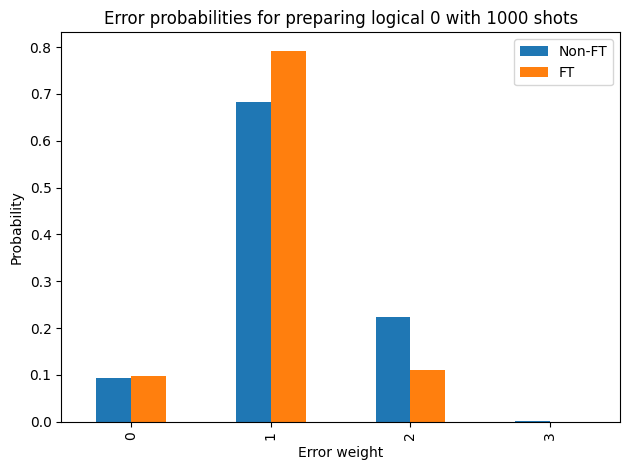

In [11]:
shots = 1000
flag_inds = [1,2,4,5,7,8]

noise_1q = 'Z'
noise_2q = 'Z'
meas_noise = 1e-2
noise_prob_1q = 1e-2 # depolarizing noise
noise_prob_2q = 1e-2 # depolarizing noise


states, obs_results, measurements = run_noisy_stabilizer_circuit(
    gate_sequence, num_qubits, num_meas, shots, observables, 
    noise_1q, noise_2q, meas_noise, noise_prob_1q, noise_prob_2q, verbose=True
    )

unflagged = np.where(measurements[:,flag_inds].sum(1) == 0)
probs_nonFT = [np.round((obs_results @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
probs_FT = [np.round((obs_results[unflagged] @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
df = pd.DataFrame(np.stack([probs_nonFT, probs_FT]).T, columns=['Non-FT', 'FT'], index=[f'{i}' for i in range(4)])
df.plot(kind='bar', title=f'Error probabilities for preparing logical 0 with {shots} shots', ylabel='Probability', xlabel='Error weight')
plt.tight_layout()

## Depolarizing noise + measurement noise

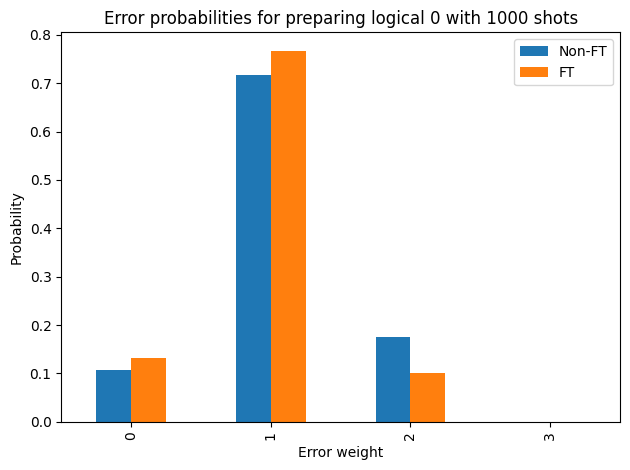

In [12]:
shots = 1000
flag_inds = [1,2,4,5,7,8]

noise_1q = 'XYZ'
noise_2q = 'XYZ'
meas_noise = 1e-2
noise_prob_1q = 1e-2 # depolarizing noise
noise_prob_2q = 1e-2 # depolarizing noise


states, obs_results, measurements = run_noisy_stabilizer_circuit(
    gate_sequence, num_qubits, num_meas, shots, observables, 
    noise_1q, noise_2q, meas_noise, noise_prob_1q, noise_prob_2q, verbose=True
    )

unflagged = np.where(measurements[:,flag_inds].sum(1) == 0)
probs_nonFT = [np.round((obs_results @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
probs_FT = [np.round((obs_results[unflagged] @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
df = pd.DataFrame(np.stack([probs_nonFT, probs_FT]).T, columns=['Non-FT', 'FT'], index=[f'{i}' for i in range(4)])
df.plot(kind='bar', title=f'Error probabilities for preparing logical 0 with {shots} shots', ylabel='Probability', xlabel='Error weight')
plt.tight_layout()

## Asymmetric depol 1q + depol 2q + measurement noise

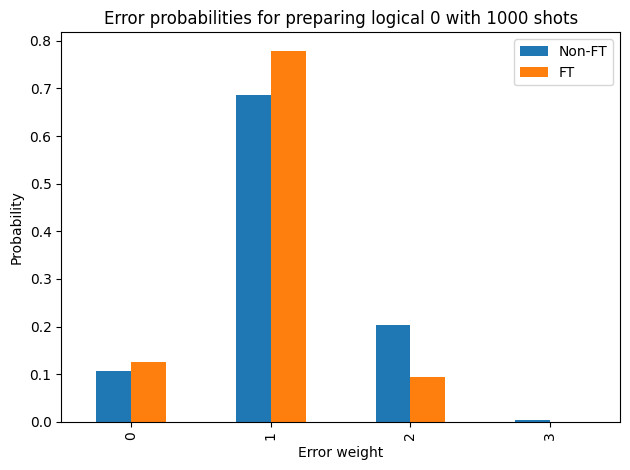

In [13]:
shots = 1000
flag_inds = [1,2,4,5,7,8]

noise_1q = 'XYZ'
noise_2q = 'XYZ'
meas_noise = 1e-2
noise_prob_1q = [1e-3,1e-3,1e-2] # asymmetric depolarizing (more bias towards Z)
noise_prob_2q = 1e-2 # symmetric depolarizing


states, obs_results, measurements = run_noisy_stabilizer_circuit(
    gate_sequence, num_qubits, num_meas, shots, observables, 
    noise_1q, noise_2q, meas_noise, noise_prob_1q, noise_prob_2q, verbose=True
    )

unflagged = np.where(measurements[:,flag_inds].sum(1) == 0)
probs_nonFT = [np.round((obs_results @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
probs_FT = [np.round((obs_results[unflagged] @ obs_unique[i].T).sum(1).mean(0)/num_obs,10) for i in range(4)]
df = pd.DataFrame(np.stack([probs_nonFT, probs_FT]).T, columns=['Non-FT', 'FT'], index=[f'{i}' for i in range(4)])
df.plot(kind='bar', title=f'Error probabilities for preparing logical 0 with {shots} shots', ylabel='Probability', xlabel='Error weight')
plt.tight_layout()